In [17]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import (
    color, feature, filters, measure, morphology, segmentation, util
)
import cv2
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops, regionprops_table
from skimage.morphology import closing, square
from skimage.color import label2rgb
import plotly
import plotly.express as px
import plotly.graph_objects as go
import math
import pandas as pd
from napari_simpleitk_image_processing import threshold_otsu, touching_objects_labeling, gaussian_blur
from pyclesperanto_prototype import imshow
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

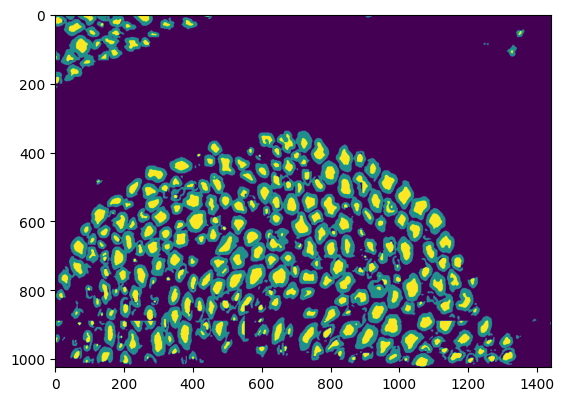

In [18]:
img_path = r"D:\Research\Isaacs Lab\23G-15\23G-15_07\23G-15_40X_07_0004\image_seg-axonmyelin.png"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)

In [19]:
axon = cv2.inRange(img, 200, 256)
myelin = cv2.inRange(img, 1, 256)

In [20]:
def get_labels(img):
    distance = ndi.distance_transform_edt(img)
    coords = peak_local_max(distance, footprint=np.ones((50, 50)), labels=img)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(-distance, markers, mask=img)
    return labels

273


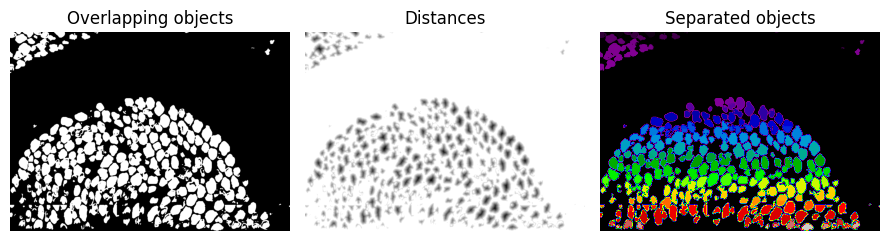

In [21]:
distance = ndi.distance_transform_edt(myelin)
coords = peak_local_max(distance, footprint=np.ones((50,50)), labels=myelin)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=myelin)
print(labels.max())

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(myelin, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

In [22]:
# axon_touch_label = touching_objects_labeling(axon)
axon_label = get_labels(axon)
axon_props = regionprops_table(axon_label,properties=('label', 'centroid', 'area', 'axis_major_length', 'eccentricity', 'orientation', 'perimeter', 'solidity'))
axon_df = pd.DataFrame.from_dict(axon_props)

# myelin_touch_label = touching_objects_labeling(myelin)
myelin_label = get_labels(myelin)
myelin_props = regionprops_table(myelin_label, properties=('label', 'bbox', 'area', 'axis_major_length', 'perimeter'))
myelin_df = pd.DataFrame.from_dict(myelin_props)

In [23]:
columns = {'label':[],
               'x':[],
               'y':[],
               'axon_area':[],
               'axon_perimeter':[],
               'axon_diam':[],
               'myelin_area':[],
               'myelin_thickness':[],
               'myelin_perimeter':[],
               'eccentricity':[],
               'orientation':[],
               'solidity':[],
               'gratio':[]}
morph_df = pd.DataFrame(columns)

In [24]:
'''
   0        1        2        3
min_row, min_col, max_row, max_col
'''

'\n   0        1        2        3\nmin_row, min_col, max_row, max_col\n'

In [25]:
x, y = (0,121)
myelin_df[((myelin_df['bbox-0'] <= x) & (myelin_df['bbox-2'] >= x)) & ((myelin_df['bbox-1'] <= y) & (myelin_df['bbox-3'] >= y))]

,label,bbox-0,bbox-1,bbox-2,bbox-3,area,axis_major_length,perimeter
6,7,0,121,39,200,1659.0,82.942809,267.894444


In [26]:
def contains(arr, target):
    return any(np.array_equal(sub_arr, target) for sub_arr in arr)

In [27]:
def get_myelin_row(myelin_df, x, y):
    x = int(x)
    y = int(y)
    return myelin_df[((myelin_df['bbox-0'] <= x) & (myelin_df['bbox-2'] >= x)) & ((myelin_df['bbox-1'] <= y) & (myelin_df['bbox-3'] >= y))]

In [28]:
for index, row in axon_df.iterrows():
    label = row['label']
    x = row['centroid-0']
    y = row['centroid-1']
    axon_area = row['area']
    axon_perimeter = row['perimeter']
    axon_diam = row['axis_major_length']
    eccentricity = row['eccentricity']
    orientation = row['orientation']
    solidity = row['solidity']
    myelin_row = get_myelin_row(myelin_df, x, y)
    myelin_area = myelin_row['area'] - axon_area
    myelin_thickness = myelin_row['axis_major_length'] - axon_diam
    myelin_perimeter = myelin_row['perimeter']
    gratio = axon_diam / myelin_row['axis_major_length']
    
    new_dict = {'label':label,
               'x':x,
               'y':y,
               'axon_area':axon_area,
               'axon_perimeter':axon_perimeter,
               'axon_diam':axon_diam,
               'myelin_area':myelin_area,
               'myelin_thickness':myelin_thickness,
               'myelin_perimeter':myelin_perimeter,
               'eccentricity':eccentricity,
               'orientation':orientation,
               'solidity':solidity,
               'gratio':gratio}
    new_df = pd.DataFrame(new_dict)
    
    morph_df = pd.concat([morph_df,new_df], ignore_index=True)

In [29]:
morph_df

,label,x,y,axon_area,axon_perimeter,axon_diam,myelin_area,myelin_thickness,myelin_perimeter,eccentricity,orientation,solidity,gratio
0,1.0,1.705882,43.500000,34.0,19.656854,8.359567,342.0,20.243886,76.284271,0.776078,1.570796,1.000000,0.292257
1,2.0,9.001792,257.120072,558.0,98.870058,36.028869,836.0,20.449319,156.325902,0.819396,1.205262,0.967071,0.637925
2,3.0,3.382609,439.600000,115.0,41.556349,17.944756,88.0,6.852401,75.384776,0.889731,1.420867,0.966387,0.723662
3,4.0,5.796209,92.767773,211.0,56.384776,20.387822,992.0,33.525570,150.911688,0.734005,1.313015,0.921397,0.378159
4,5.0,12.112676,103.788732,142.0,49.455844,17.795537,1061.0,36.117855,150.911688,0.776639,-0.352760,0.860606,0.330076
...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,317.0,998.925781,1264.996094,256.0,61.698485,19.284201,2228.0,84.051609,527.173665,0.435711,1.480966,0.927536,0.186617
325,318.0,1001.935484,1015.903226,62.0,27.899495,9.509218,1793.0,56.235581,279.965512,0.458415,-0.645586,0.925373,0.144638
326,319.0,1003.573099,1203.754386,171.0,50.627417,19.209835,2313.0,84.125975,527.173665,0.794299,-0.835285,0.939560,0.185897
327,320.0,1002.883721,204.480620,258.0,66.627417,25.689129,704.0,15.255842,133.154329,0.840744,0.010825,0.883562,0.627406


In [30]:
total_axon_area = morph_df['axon_area'].sum()
total_myelin_area = morph_df['myelin_area'].sum()
total_area = img.size

avf = total_axon_area / total_area
mvf = total_myelin_area / total_area

agg_gratio = math.sqrt(1 / (1 + (mvf/avf)))

In [31]:
agg_gratio

0.48746561286104756